In [1]:
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN

sns.set(font_scale=1.2, style='ticks')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
colors = sns.color_palette()

from src.train import estimate_mutual_information, train_estimator
from src.utils import mi_schedule

In [2]:
rerun_experiments = False # Set to True if you would like to rerun all the experiments

In [3]:
gaussian_dim = 20
data_params = {
    'dim': gaussian_dim,
    'batch_size': 128,
    'cubic': None
}

critic_params = {
    'dim': gaussian_dim,
    'layers': 1,
    'embed_dim': 512,
    'hidden_dim': 512,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 1e-3,
}

infonce
nwj
js
smile
rpc


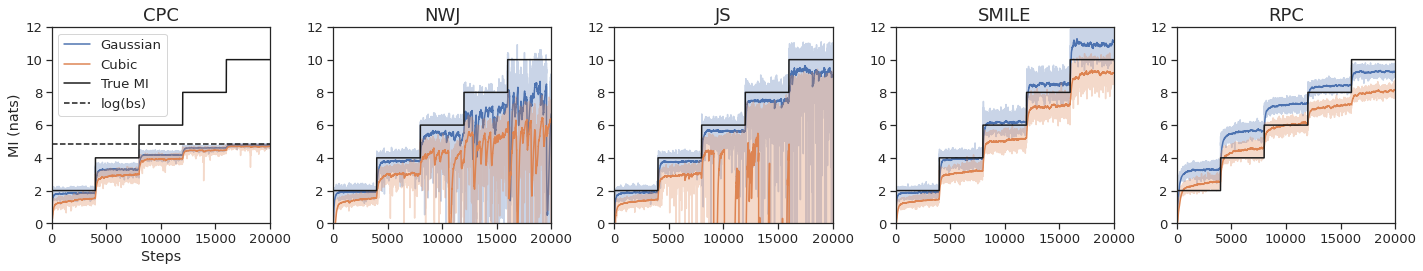

In [4]:
# Comparisons of different objectives
estimator_lists = ['infonce', 'nwj', 'js', 'smile', 'rpc']

if rerun_experiments:
    for cubic in [None, True]:
        data_params['cubic'] = cubic
        for batch_size in [data_params['batch_size']]:
            print('batch_size: ', batch_size)
            mi_numpys = dict()
            train_objs_numpys = dict()
            for critic_type in ['concat']:
                mi_numpys[critic_type] = dict()
                train_objs_numpys[critic_type] = dict()
                for estimator in estimator_lists:
                    if estimator == 'rpc':
                        estimator = 'gen-chi'
                    baseline_string = 'unnormalized' if estimator == 'tuba' else 'constant'
                    mi_params = dict(estimator=estimator, critic=critic_type, baseline=baseline_string)
                    if estimator == 'gen-chi':
                        mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params, alpha=1.0, beta=0.0001,gamma=1.0)
                    else:
                        mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params)
                    mi_numpys[critic_type][f'{estimator}'] = mis
                    train_objs_numpys[critic_type][f'{estimator}'] = train_objs

                    print('estimator', estimator)

            cubic_str = '' if cubic is None else '_cubic'
            np.savez(f'baselines_mi_values{cubic_str}_{str(batch_size)}.npz', **mi_numpys)
            np.savez(f'baselines_train_objs_values{cubic_str}_{str(batch_size)}.npz', **train_objs_numpys)
        
batch_size = data_params['batch_size']
mi_numpys = np.load(f'baselines_mi_values_{str(batch_size)}.npz', allow_pickle=True)
mi_numpys_cubic = np.load(f'baselines_mi_values_cubic_{str(batch_size)}.npz', allow_pickle=True)

def find_name(name):
    if 'dv_clip_' in name:
        clip = name.split('_')[-1]
        return f'dv_clip_ ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'dv': 'DV',
            'rpc': 'RPC',
            'smile': 'SMILE'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]
    
ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
        
for i, estimator in enumerate(estimator_lists):
    key = f'{estimator}'
    plt.sca(axs[i])
    print(key)
    plt.title(find_name(key), fontsize=18)
    for net in ['concat']:
        if key == 'rpc':
            key = 'gen-chi'
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]

        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label='Gaussian')
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label='Cubic')
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if estimator == 'infonce':  
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.axhline(np.log(128), color='k', ls='--', label='log(bs)')
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f'baselines_mi_gauss_results_{str(batch_size)}.pdf', bbox_inches=None)

rco-alpha-0.01
rco-alpha-0.1
rco-alpha-0.5
rco-alpha-1.0
rco-alpha-2.0


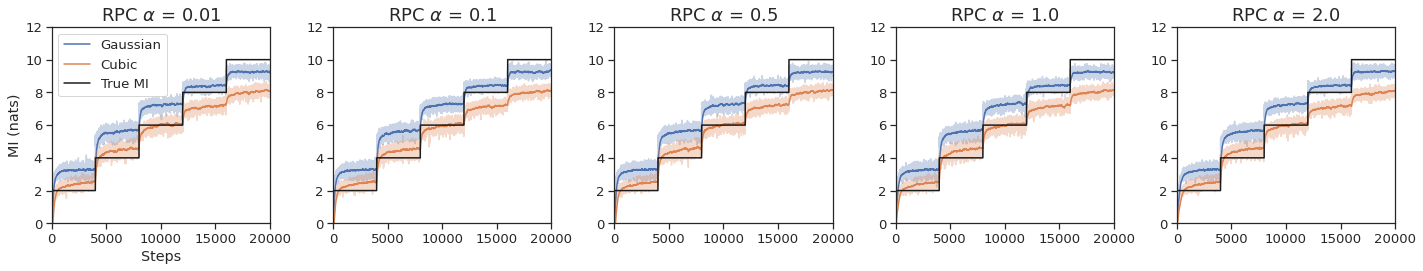

In [5]:
# Experiments testing different relative parameters alpha

# RCO here refers to the relative predictive coding objective

estimator_lists = ['rco-alpha-0.01', 'rco-alpha-0.1', 'rco-alpha-0.5', 'rco-alpha-1.0', 'rco-alpha-2.0']
alphas = [0.01, 0.1, 0.5, 1.0, 2.0]
if rerun_experiments:
    for cubic in [None, True]:
        data_params['cubic'] = cubic
        for batch_size in [data_params['batch_size']]:
            print('batch_size: ', batch_size)
            mi_numpys = dict()
            train_objs_numpys = dict()
            for critic_type in ['concat']:
                mi_numpys[critic_type] = dict()
                train_objs_numpys[critic_type] = dict()
                for i, estimator in enumerate(estimator_lists):
                    baseline_string = 'unnormalized' if estimator == 'tuba' else 'constant'
                    mi_params = dict(estimator='gen-chi', critic=critic_type, baseline=baseline_string)
                    mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params, alpha=alphas[i], beta=0.0001,gamma=1.0)
                    mi_numpys[critic_type][f'{estimator}'] = mis
                    train_objs_numpys[critic_type][f'{estimator}'] = train_objs

            cubic_str = '' if cubic is None else '_cubic'
            np.savez(f'baselines_mi_values{cubic_str}_{str(batch_size)}_alphas.npz', **mi_numpys)
            np.savez(f'baselines_train_objs_values{cubic_str}_{str(batch_size)}_alphas.npz', **train_objs_numpys)


batch_size = data_params['batch_size']
mi_numpys = np.load(f'baselines_mi_values_{str(batch_size)}_alphas.npz', allow_pickle=True)
mi_numpys_cubic = np.load(f'baselines_mi_values_cubic_{str(batch_size)}_alphas.npz', allow_pickle=True)

def find_name(name):
    if 'dv_clip_' in name:
        clip = name.split('_')[-1]
        return f'dv_clip_ ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'dv': 'DV',
            'rpc': 'RPC',
            'smile': 'SMILE'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]
    
ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
        
for i, estimator in enumerate(estimator_lists):
    key = f'{estimator}'
    plt.sca(axs[i])
    print(key)
    alpha = alphas[i]
    plt.title("RPC " + r'$\alpha$ = ' + str(alpha), fontsize=18)
    for net in ['concat']:
        if key == 'rpc':
            key = 'gen-chi'
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]

        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label='Gaussian')
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label='Cubic')
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:  
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f'baselines_mi_gauss_results_{str(batch_size)}.pdf', bbox_inches=None)

rco-beta-1e-5
rco-beta-1e-4
rco-beta-1e-3
rco-beta-1e-2
rco-beta-1e-1


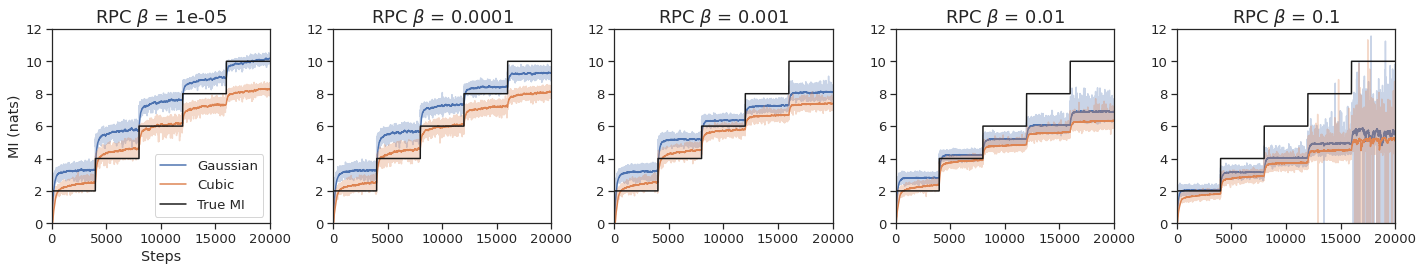

In [6]:
# Experiments testing different relative parameters beta

estimator_lists = ['rco-beta-1e-5', 'rco-beta-1e-4', 'rco-beta-1e-3', 'rco-beta-1e-2', 'rco-beta-1e-1']
betas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

if rerun_experiments:
    for cubic in [None, True]:
        data_params['cubic'] = cubic
        for batch_size in [data_params['batch_size']]:
            print('batch_size: ', batch_size)
            mi_numpys = dict()
            train_objs_numpys = dict()
            for critic_type in ['concat']:
                mi_numpys[critic_type] = dict()
                train_objs_numpys[critic_type] = dict()
                for i, estimator in enumerate(estimator_lists):
                    baseline_string = 'unnormalized' if estimator == 'tuba' else 'constant'
                    mi_params = dict(estimator='gen-chi', critic=critic_type, baseline=baseline_string)
                    mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params, alpha=1, beta=betas[i],gamma=1.0)
                    mi_numpys[critic_type][f'{estimator}'] = mis
                    train_objs_numpys[critic_type][f'{estimator}'] = train_objs

            cubic_str = '' if cubic is None else '_cubic'
            np.savez(f'baselines_mi_values{cubic_str}_{str(batch_size)}_betas.npz', **mi_numpys)
            np.savez(f'baselines_train_objs_values{cubic_str}_{str(batch_size)}_betas.npz', **train_objs_numpys)

batch_size = data_params['batch_size']
mi_numpys = np.load(f'baselines_mi_values_{str(batch_size)}_betas.npz', allow_pickle=True)
mi_numpys_cubic = np.load(f'baselines_mi_values_cubic_{str(batch_size)}_betas.npz', allow_pickle=True)

def find_name(name):
    if 'dv_clip_' in name:
        clip = name.split('_')[-1]
        return f'dv_clip_ ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'dv': 'DV',
            'rpc': 'RPC',
            'smile': 'SMILE'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]
    
ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
        
for i, estimator in enumerate(estimator_lists):
    key = f'{estimator}'
    plt.sca(axs[i])
    print(key)
    beta = betas[i]
    plt.title("RPC " + r'$\beta$ = ' + str(beta), fontsize=18)
    for net in ['concat']:
        if key == 'rpc':
            key = 'gen-chi'
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]

        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label='Gaussian')
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label='Cubic')
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:  
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f'baselines_mi_gauss_results_{str(batch_size)}.pdf', bbox_inches=None)        

rco-gamma-0.01
rco-gamma-0.1
rco-gamma-0.5
rco-gamma-1.0
rco-gamma-2.0


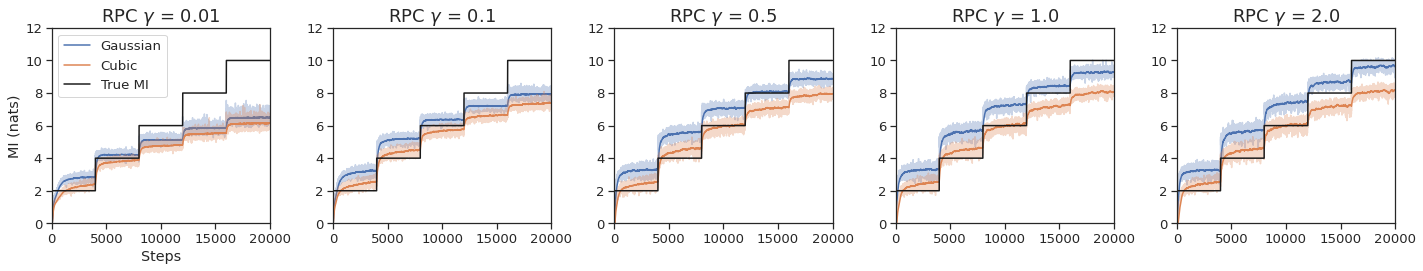

In [7]:
# Experiments testing different relative parameters gamma

estimator_lists = ['rco-gamma-0.01', 'rco-gamma-0.1', 'rco-gamma-0.5', 'rco-gamma-1.0', 'rco-gamma-2.0']
gammas = [0.01, 0.1, 0.5, 1.0, 2.0]
if rerun_experiments:
    for cubic in [None, True]:
        data_params['cubic'] = cubic
        for batch_size in [data_params['batch_size']]:
            print('batch_size: ', batch_size)
            mi_numpys = dict()
            train_objs_numpys = dict()
            for critic_type in ['concat']:
                mi_numpys[critic_type] = dict()
                train_objs_numpys[critic_type] = dict()
                for i, estimator in enumerate(estimator_lists):
                    baseline_string = 'unnormalized' if estimator == 'tuba' else 'constant'
                    mi_params = dict(estimator='gen-chi', critic=critic_type, baseline=baseline_string)
                    mis, train_objs = train_estimator(critic_params, data_params, mi_params, opt_params, alpha=1.0, beta=0.0001,gamma=gammas[i])
                    mi_numpys[critic_type][f'{estimator}'] = mis
                    train_objs_numpys[critic_type][f'{estimator}'] = train_objs

            cubic_str = '' if cubic is None else '_cubic'
            np.savez(f'baselines_mi_values{cubic_str}_{str(batch_size)}_gammas.npz', **mi_numpys)
            np.savez(f'baselines_train_objs_values{cubic_str}_{str(batch_size)}_gammas.npz', **train_objs_numpys)


batch_size = data_params['batch_size']
mi_numpys = np.load(f'baselines_mi_values_{str(batch_size)}_gammas.npz', allow_pickle=True)
mi_numpys_cubic = np.load(f'baselines_mi_values_cubic_{str(batch_size)}_gammas.npz', allow_pickle=True)

def find_name(name):
    if 'dv_clip_' in name:
        clip = name.split('_')[-1]
        return f'dv_clip_ ($\\tau = {clip}$)'
    else:
        return {
            'infonce': 'CPC',
            'js': 'JS',
            'nwj': 'NWJ',
            'dv': 'DV',
            'rpc': 'RPC',
            'smile': 'SMILE'
        }[name]

def find_legend(label):
    return {'concat': 'Joint critic', 'separable': 'Separable critic'}[label]
    
ncols = len(estimator_lists)
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axs = np.ravel(axs)

mi_true = mi_schedule(opt_params['iterations'])
        
for i, estimator in enumerate(estimator_lists):
    key = f'{estimator}'
    plt.sca(axs[i])
    print(key)
    gamma = gammas[i]
    plt.title("RPC " + r'$\gamma$ = ' + str(gamma), fontsize=18)
    for net in ['concat']:
        if key == 'rpc':
            key = 'gen-chi'
        mis = mi_numpys[net].item()[key]
        mis_cubic = mi_numpys_cubic[net].item()[key]

        EMA_SPAN = 200
        p1 = plt.plot(mis, alpha=0.3)[0]
        mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth, c=p1.get_color(), label='Gaussian')
        p2 = plt.plot(mis_cubic, alpha=0.3)[0]
        mis_smooth_cubic = pd.Series(mis_cubic).ewm(span=EMA_SPAN).mean()
        plt.plot(mis_smooth_cubic, c=p2.get_color(), label='Cubic')
    plt.ylim(0, 12)
    plt.xlim(0, 20000)
    plt.plot(mi_true, color='k', label='True MI')
    if i == 0:  
        plt.ylabel('MI (nats)')
        plt.xlabel('Steps')
        plt.legend()

plt.gcf().tight_layout()
plt.savefig(f'baselines_mi_gauss_results_{str(batch_size)}.pdf', bbox_inches=None)